# Chapter 7
# Decision Trees
## 7.1 Predicting the Price of a Used Car
### 7.1.2 How to Build a Decision Tree

To understand how decision trees are built, let's l the dataset behind the tree in figure 7-5 is the `12-cars.csv` dataset:

In [1]:
import pandas as pd
%matplotlib inline

cars_12 = pd.read_csv('../datasets/12-cars.csv', index_col=0)
cars_12

,Year,Engine,Power,Price
0,2003,1700,80,185
1,2005,1500,73,160
2,2008,1800,84,195
3,2009,1200,61,252
4,2010,1100,87,237
5,2016,1500,83,261
6,2012,1800,63,312
7,2011,1750,67,280
8,2010,1900,75,308
9,2009,1800,83,410


### 7.1.3 Coding a Primative Decision Tree

Decisions trees are built by recursively splitting regions of sapce into two sub-regions in order to minimize the mean squared error (MSE) across the training data. In each split, we choose the best pair of (feature, value) that would yeild the minimal MSE. We call this pair a **_pivot_**. To write a simple code that can apply this procedure and build us a decision tree on the 12-cars dataset, we first need to define the `Node` class which be the data structure holding the tree. 

In [2]:
class Node:
    
    def __init__(self, is_leaf=False, pivot=None):
        self.is_leaf = is_leaf
        self.pivot = pivot
        
    def attach_children(self, left, right):
        self.left_child = left
        self.right_child = right
        
    def attach_leaf_value(self, mean_value):
        self.leaf_value = mean_value
        
    def traverse(self, x):
        if not self.is_leaf:
            feature_indx, value = self.pivot
            if x[feature_indx] <= value:
                return self.left_child.traverse(x)
            else:
                return self.right_child.traverse(x)
        else:
            return self.leaf_value

The `Node` class represents a node in the decision tree, with left and right child nodes attached if the node is not a leaf node. With these properties, the root node object would represent the whole decision tree as it has links to all the child nodes underneath it. The `traverse` method allow us to travel down the tree with a given data point: on each decision node, comparison against the pivot is made to determine to which child shall we traverse next, until we reach a leaf node where we'll return the attached mean value of the labels in that leaf node region.

Next, we need to use the `Node` class in order to build the whole tree. We do so by defining a class called `PrimitiveDecisionTreeRegressor` that will hold our tree-building code. The two main method in that class are the `get_best_pivot` and the `split` methods. `get_best_pivot` enumerates all the possible values for each feature calculates the splitting MSE for each splitting option, the option with the smallest MSE is returned. The `split` method uses the `get_best_pivot` method to recursively split regions into two sub-regions until we hit the stopping criteria. 

In [3]:
import numpy as np

def mse(y_true, y_pred):
    # Calculating the mean square error (MSE)
    return np.mean((y_true - y_pred) ** 2)

class PrimitiveDecisionTreeRegressor:
    
    def __init__(self, stop_at=3):
        self.stop_at = stop_at
        self.tree = None
        
    def get_best_pivot(self, region_X, region_y):
        
        samples_count, features_count = region_X.shape
        
        # record each feature index with its possible values in a dictionary
        features_split_points = {}
        for i in range(features_count):
            features_split_points[i] = np.sort(region_X[:, i])
        
        # minimal mse is set to infinity at start
        minimal_mse = np.inf 
        best_pivot = (None, None)
        
        # we loop over all pairs of (feature_index, value)
        for i in range(features_count):
            for value in features_split_points[i]:
                
                # we make use of boolean masks to get the samples in each subregion
                left_region_mask = region_X[:, i] <= value
                right_region_mask = ~left_region_mask
                
                # we check the number of samples in each subregion
                # if it's lower than the stopping critreia, we omit that split
                left_region_X = region_X[left_region_mask]
                right_region_X = region_X[right_region_mask] 
                
                if left_region_X.shape[0] < self.stop_at or \
                    right_region_X.shape[0] < self.stop_at:
                    continue
                
                # we get the y values in each region and calculate the split MSE
                left_region_y = region_y[left_region_mask]
                right_region_y = region_y[right_region_mask]
                
                left_mse = mse(left_region_y, np.mean(left_region_y))
                right_mse = mse(right_region_y, np.mean(right_region_y))
                total_mse = left_mse + right_mse
                
                # if the split MSE is lower than the prvious best
                # we set the current split as the best one
                if total_mse < minimal_mse:
                    minimal_mse = total_mse
                    best_pivot = (i, value)
                    
        return best_pivot
        
        
    def split(self, region_X, region_y, level=1):
        
        samples_count, _ = region_X.shape
        
        # if the samples count in the region to split meets
        # the stopping criteria, stop recursion and return a leaf node
        if samples_count <= self.stop_at:
            leaf_node = Node(is_leaf=True)
            leaf_node.attach_leaf_value(np.mean(region_y))
            return leaf_node
    
        # get the best pivot at this step and craete a decision node            
        split_feature, split_value = self.get_best_pivot(region_X, region_y)
        current_node = Node(pivot=(split_feature, split_value))
        
        
        print("{}Split on feature {} at {}".format(
            ''.join(['\t'] * level), 
            split_feature, 
            split_value)
        )
        
        left_region_mask = region_X[:, split_feature] <= split_value
        right_region_mask = ~left_region_mask
        
        # recursivly split the left subregion and get its root node
        print("{}Left Region:".format(''.join(['\t'] * level)))
        left_region_X = region_X[left_region_mask]
        left_region_y = region_y[left_region_mask]
        left_child = self.split(left_region_X, left_region_y, level + 1)
        
        # recursivly split the right subregion and get its root node
        print("{}Right Region:".format(''.join(['\t'] * level)))
        right_region_X = region_X[right_region_mask]
        right_region_y = region_y[right_region_mask]
        right_child = self.split(right_region_X, right_region_y, level + 1)
        
        # attach the left and right subregions to the decision node
        current_node.attach_children(left_child, right_child)
        
        return current_node
    
    def fit(self, X, y):
        self.tree = self.split(X, y)
        
    def predict(self, x):
        return self.tree.traverse(x)

With this implementation, we're ready to train a decision tree on the 12-cars data we have. We made the implementation following the `scikit-learn` convention of fit/predict for consistency, we also added print statments that would layout how the tree is built to see if the splits matches the one we assumed true while we're visually building the tree in figure 7-8. Fitting the model would show us that the spilts are indeed correct.

In [4]:
X_train = cars_12.loc[:, "Year":"Power"].to_numpy()
y_train = cars_12.loc[:, "Price"].to_numpy()

primitive_dt = PrimitiveDecisionTreeRegressor()
primitive_dt.fit(X_train, y_train)

	Split on feature 0 at 2008
	Left Region:
	Right Region:
		Split on feature 1 at 1500
		Left Region:
		Right Region:
			Split on feature 2 at 75
			Left Region:
			Right Region:


And if we ran our testing example through the `predict` example, we would get the prediction of 300K as we stated before.

In [5]:
x_test = np.array([2012, 1600, 73])

primitive_dt.predict(x_test)

300.0

## 7.2 Building Decision Trees with scikit-learn
We start building a solution to the used cars price prediction problem by taking a look at the dataset we're going to work on:

In [6]:
import pandas as pd

data = pd.read_csv("../datasets/used-cars.csv")
data.sample(10, random_state=42)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2868,2868,Maruti Swift Dzire VDI,Hyderabad,2013,69000,Diesel,Manual,First,23.4 kmpl,1248 CC,74 bhp,5.0,NaN,5.75
5924,5924,Mahindra Scorpio 1.99 S4 Plus,Kochi,2017,26741,Diesel,Manual,First,15.4 kmpl,1997 CC,120 bhp,7.0,NaN,10.08
3764,3764,Mahindra XUV500 W8 2WD,Delhi,2014,86000,Diesel,Manual,First,15.1 kmpl,2179 CC,140 bhp,7.0,NaN,7.85
4144,4144,Tata Indigo CS eVX,Pune,2016,52000,Diesel,Manual,Second,25.0 kmpl,1396 CC,69.01 bhp,5.0,NaN,2.40
2780,2780,Hyundai Santro GLS II - Euro II,Pune,2009,100000,Petrol,Manual,First,0.0 kmpl,NaN,NaN,NaN,NaN,1.60
1514,1514,Honda Accord 2.4 AT,Mumbai,2008,125000,Petrol,Automatic,Third,11.7 kmpl,2354 CC,177.6 bhp,5.0,NaN,2.60
1199,1199,Nissan Terrano XL,Mumbai,2014,28238,Petrol,Manual,First,13.24 kmpl,1598 CC,102.5 bhp,5.0,NaN,5.55
84,84,Maruti Ritz VDi,Jaipur,2013,99638,Diesel,Manual,First,23.2 kmpl,1248 CC,73.94 bhp,5.0,NaN,3.11
1219,1219,Honda CR-V 2.4L 4WD AT AVN,Kolkata,2013,46125,Petrol,Automatic,Second,12.0 kmpl,2354 CC,187.4 bhp,5.0,NaN,12.50
1554,1554,Maruti Ritz VXI,Hyderabad,2012,68776,Petrol,Manual,First,21.1 kmpl,1197 CC,85.80 bhp,5.0,NaN,3.90


Our data sample shows two problems that needs to be fixed before we can move forward:

1. The Mileage, Engine and Power data has their units attached to them, which makes `pandas` treat them a strings and hence categorical data. This data needs to be treated as numerical data.
2. There is a lot of `NaN`s and `0`s in the numeric columns, which indicates missing data that needs to filled

### 7.2.1 Preparing the Data

We start first by stripping the units from the numeric values and casting the remaining string into floats. This can be simply done using the `apply` method which applies a given function on all the elements of a `DataFrame`/`Series` and returns the result in a new `DataFrame`/`Series`.

In [7]:
import numpy as np

clean_data = data.copy(deep=True)

def strip_units(str_value):
    
    float_value = np.nan
    
    if str_value is not np.nan:
        number_str, units = str_value.split()
        try:
            float_value = float(number_str)
        except Exception:
            pass
    
    return float_value

def brand_name(s):
    tockenized_name = s.split()
    brand_name = tockenized_name[0]
    
    return brand_name


clean_data.loc[:, 'Name'] = data.loc[:, 'Name'].apply(brand_name)
clean_data.loc[:, 'Mileage'] = data.loc[:, 'Mileage'].apply(strip_units)
clean_data.loc[:, 'Engine'] = data.loc[:, 'Engine'].apply(strip_units)
clean_data.loc[:, 'Power'] = data.loc[:, 'Power'].apply(strip_units)

A simple call to `clean_data.sample(10, random_sample=42)` will reveal that the units were stripped from the numeric values.

In [8]:
clean_data.sample(10, random_state=42)

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
2868,2868,Maruti,Hyderabad,2013,69000,Diesel,Manual,First,23.40,1248.0,74.00,5.0,NaN,5.75
5924,5924,Mahindra,Kochi,2017,26741,Diesel,Manual,First,15.40,1997.0,120.00,7.0,NaN,10.08
3764,3764,Mahindra,Delhi,2014,86000,Diesel,Manual,First,15.10,2179.0,140.00,7.0,NaN,7.85
4144,4144,Tata,Pune,2016,52000,Diesel,Manual,Second,25.00,1396.0,69.01,5.0,NaN,2.40
2780,2780,Hyundai,Pune,2009,100000,Petrol,Manual,First,0.00,NaN,NaN,NaN,NaN,1.60
1514,1514,Honda,Mumbai,2008,125000,Petrol,Automatic,Third,11.70,2354.0,177.60,5.0,NaN,2.60
1199,1199,Nissan,Mumbai,2014,28238,Petrol,Manual,First,13.24,1598.0,102.50,5.0,NaN,5.55
84,84,Maruti,Jaipur,2013,99638,Diesel,Manual,First,23.20,1248.0,73.94,5.0,NaN,3.11
1219,1219,Honda,Kolkata,2013,46125,Petrol,Automatic,Second,12.00,2354.0,187.40,5.0,NaN,12.50
1554,1554,Maruti,Hyderabad,2012,68776,Petrol,Manual,First,21.10,1197.0,85.80,5.0,NaN,3.90


To start addressing the missing values problem, we first need to represent all the missing value with a single reperesentation. So instead of having both `NaN` and `0` as representations of missing values, we transform all `0` values to `NaN` values as well.

In [9]:
clean_data = clean_data.replace(0, np.nan)

With `NaN` as the representation for the missing values, we can run the following statement to get the percentage of missing values in each feature

In [10]:
clean_data.isnull().mean() * 100

Unnamed: 0            0.016614
Name                  0.000000
Location              0.000000
Year                  0.000000
Kilometers_Driven     0.000000
Fuel_Type             0.000000
Transmission          0.000000
Owner_Type            0.000000
Mileage               1.162984
Engine                0.598106
Power                 2.375810
Seats                 0.714404
New_Price            86.310018
Price                 0.000000
dtype: float64

With the big number of data missing from the `New_Price` feature, it'd be reasonable to drop that feature all together for now, along with the `Unnamed: 0` column which has no purpose.

In [11]:
clean_data = clean_data.drop(['New_Price', 'Unnamed: 0'], axis=1)

For the other features with missing values, we can apply a simple imputation startegy, which replaces each missing value with the mean value of the existing values. But before we do that, we need to encode the categorical features and make the train-test split. We encode the categrocial feature using the `OrdinalEncoder` of `sklearn.preprocessing`. We also make use of `ColumnTransformer` from `sklearn.compose` to limit the ordinal encoding to the categorical columns only.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

categorical_features = [
    'Name','Location', 'Fuel_Type', 'Transmission', 'Owner_Type'
]

encoder = ColumnTransformer([
    ('categories_encoder', OrdinalEncoder(), categorical_features)
], remainder='passthrough')

encoded_data = encoder.fit_transform(clean_data)

X, y = encoded_data[:, :-1], encoded_data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Now that we preprocessed our data, we can run the imputation process

In [13]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)

Now our data is ready to train the decision tree.

### 7.2.2 Training and Evaluating the Decision Tree

Like any scikit-learn model, training a decision tree is nothing but running the `fit` method of a `DecisionTreeRegressor` object, which can be found in the `sklearn.tree module`.

In [14]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

To evaluate our trained decision tree on the testing data, we use the `mean_squared_error` function from `sklearn.metrics`.

In [15]:
from sklearn.metrics import mean_squared_error

y_predicted = model.predict(X_test)
mse = mean_squared_error(y_true=y_test, y_pred=y_predicted)
print("MSE = {:.2f}".format(mse))

MSE = 31.37


Because MSE is not an absolute-valued score and doesn't tell us much information about the model's quality on its own, another score is used which has a nice interpretation like accuracy have in classification settings. That score is called R-squared, and it captures the fraction of variance in the labels explained by the model. This score can be calculated using the `r2_score` function from `sklearn.metrics`, or through the `score` method of any regression model in scikit-learn

In [16]:
r2 = model.score(X_test, y_test)
print("R-squared = {:.2f}".format(r2))

R-squared = 0.75


In [17]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true=y_test, y_pred=y_predicted)
print("MAE = {:.2f}".format(mae))

MAE = 2.20


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff498fcae10>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff498edeeb8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff498ede550>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff498e75940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff498e75c88>],
 'means': []}

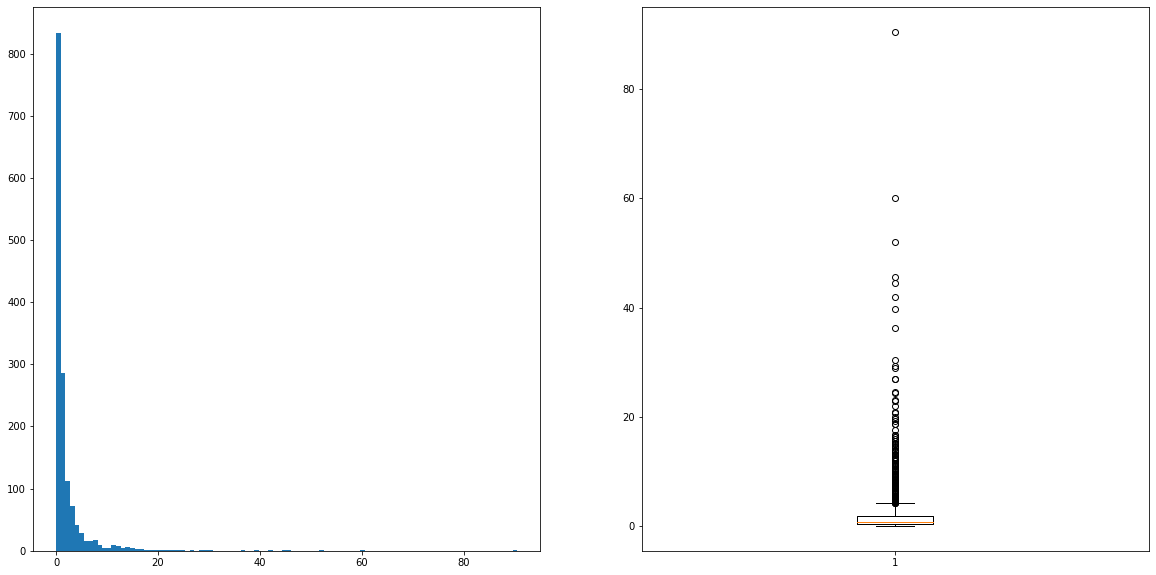

In [18]:
import matplotlib.pyplot as plt

absolute_errors = np.abs(y_predicted - y_test)
fig = plt.figure(figsize=(20, 10))
ax1, ax2 = fig.subplots(nrows=1, ncols=2)
ax1.hist(absolute_errors, bins=100)
ax2.boxplot(absolute_errors)

In [19]:
from sklearn.metrics import median_absolute_error

medae = median_absolute_error(y_true=y_test, y_pred=y_predicted)
print("MedAE = {:.2f}".format(medae))

MedAE = 0.75


In [68]:
!conda install -y python-graphviz

Solving environment: done

# All requested packages already installed.



In [21]:
from sklearn.tree import export_graphviz
import graphviz

numerical_features = [
    'Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats'
]

dot_data = export_graphviz(
    model,
    # This allows the visualization to put feature names in decision nodes
    feature_names=categorical_features + numerical_features,
    # This makes the nodes with rounded corners
    rounded=True,
    # fills the nodes with gradient of colors indicating how high/low the decision value is
    filled=True,
    # uses special charcaters like ≤ instead of <
    special_characters=True
)

visualized_tree = graphviz.Source(dot_data)
visualized_tree.render("visulaized_tree")

'visulaized_tree.pdf'

In [20]:
training_count, _ = X_train.shape
leaves_count = model.get_n_leaves()

print("{} data samples are put into {} leaf nodes".format(
    training_count, leaves_count
))

4514 data samples are put into 4300 leaf nodes


In [21]:
from utils import estimate_tree_variance

tree_var = estimate_tree_variance(X, y)
print("Estimated Tree Variance = {:.2f}".format(tree_var))

Estimated Tree Variance = 18.52


In [22]:
from utils import estimate_tree_variance

tree_var = estimate_tree_variance(X, y, min_samples_leaf=3)
print("Estimated Tree Variance = {:.2f}".format(tree_var))

Estimated Tree Variance = 12.67


In [218]:
X_train_sub, X_valid, y_train_sub, y_valid = train_test_split(X_train, y_train)

best_score = -np.inf
best_parameter = None
for n in range(1, 20):
    
    v_dt = DecisionTreeRegressor(random_state=42, min_samples_leaf=1)
    v_dt.fit(X_train_sub, y_train_sub)
    
    v_preds = v_dt.predict(X_valid)
    v_score = v_dt.score(X_valid, y_valid)
    
    print(v_score)
    if v_score > best_score:
        best_score = v_score
        best_parameter = n
        
print(best_parameter)

0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
0.6606648085625602
1


(array([ 5., 11., 18., 24., 23., 78., 53., 57., 56., 57., 45., 30., 15.,
        13.,  3.,  4.,  5.,  1.,  2.]),
 array([0.7325    , 0.74394737, 0.75539474, 0.76684211, 0.77828947,
        0.78973684, 0.80118421, 0.81263158, 0.82407895, 0.83552632,
        0.84697368, 0.85842105, 0.86986842, 0.88131579, 0.89276316,
        0.90421053, 0.91565789, 0.92710526, 0.93855263, 0.95      ]),
 <a list of 19 Patch objects>)

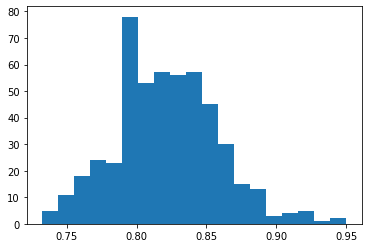

In [26]:
validation_scores = []

# This ensures that each time this script runs, it produces the same result
# without fixing the output of a random process (such as train_test_split)
# in each iteration of the loop
np.random.seed(42)

for _ in range(500):
    X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train)
    
    validation_imputer = SimpleImputer(strategy='mean')
    X_train_new = validation_imputer.fit_transform(X_train_new)
    X_valid = validation_imputer.transform(X_valid)
    
    validation_model = DecisionTreeRegressor(random_state=42, min_samples_leaf=3)
    validation_model.fit(X_train_new, y_train_new)
    
    validation_preds = validation_model.predict(X_valid)
    
    validation_scores.append(median_absolute_error(y_valid, validation_preds))

plt.hist(validation_scores, bins='fd')

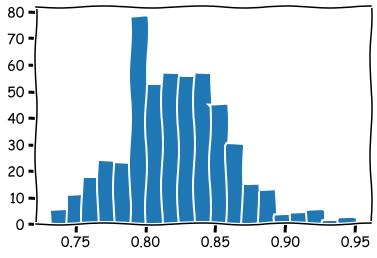

In [27]:
with plt.xkcd():
    plt.hist(validation_scores, bins='fd')

In [28]:
trimmed_model_3 = DecisionTreeRegressor(random_state=42, min_samples_leaf=6)
trimmed_model_3.fit(X_train, y_train)
y_predicted_trimmed_3 = trimmed_model_3.predict(X_test)

medae_trimmed_3 = median_absolute_error(y_test, y_predicted_trimmed_3)
print("[min_samples_leaf = 3] MedAE = {:.2f}".format(medae_trimmed_3))

[min_samples_leaf = 3] MedAE = 0.82


In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('tree', DecisionTreeRegressor(random_state=42))
])

model_selector = GridSearchCV(pipeline, param_grid={
    'tree__min_samples_leaf': np.arange(1, 20),
}, scoring='neg_median_absolute_error', cv=3)

model_selector.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('tree',
                                        DecisionTreeRegressor(ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,

In [62]:
print(model_selector.best_params_)
best_trimmed_tree = model_selector.best_estimator_

{'tree__min_samples_leaf': 4}


In [63]:
best_trimmed_preds = best_trimmed_tree.predict(X_test)
best_trimmed_medae = median_absolute_error(y_test, best_trimmed_preds)

# we access steps of the pipeline like we get values from a dict
best_trimmed_n_leaves = best_trimmed_tree['tree'].get_n_leaves()
best_trimmed_variance = estimate_tree_variance(
    X_train, y_train, min_samples_leaf=4
)

print("[min_samples_leaf = 4] MedAE = {:.2f}".format(best_trimmed_medae))
print("[min_smaples_leaf = 4] Leaves = {}".format(best_trimmed_n_leaves))
print("[min_smaples_leaf = 4] Variance = {:.2f}".format(best_trimmed_variance))

[min_samples_leaf = 4] MedAE = 0.74
[min_smaples_leaf = 4] Leaves = 913
[min_smaples_leaf = 4] Variance = 10.82


In [178]:
model_selector.best_params_

{'tree__min_samples_leaf': 4}

In [26]:
from utils import estimate_forest_variance

estimate_forest_variance(X, y)

2.132070290854977

In [24]:
estimate_tree_variance(X, y, runs=100)

19.36039318477522

In [25]:
estimate_forest_variance(X, y, runs=100)

2.1144687015132657

In [26]:
estimate_tree_variance(X, y, runs=100, min_samples_leaf=3)

12.894644095464947

In [71]:
xs, variances = [], []
train_error, test_error = [], []
max_l = 21
for n in range(1, max_l):
    xs.append(n)
    variances.append(estimate_tree_variance(X, y, runs=1000, min_samples_leaf=max_l - n))
    
    model = DecisionTreeRegressor(min_samples_leaf=max_l - n)
    model.fit(X_train, y_train)
    
    train_error.append(mean_squared_error(y_train, model.predict(X_train)))
    test_error.append(mean_squared_error(y_test, model.predict(X_test)))


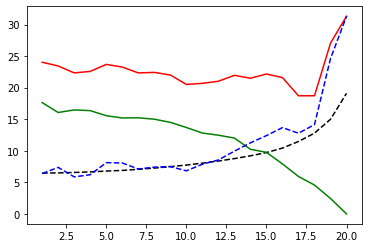

In [77]:
plt.plot(xs, np.array(variances), color='black', linestyle='--')
plt.plot(xs, (train_error), color='green')
plt.plot(xs, (test_error), color='red')
plt.plot(xs, (np.array(test_error) - np.array(train_error)), color='blue', linestyle='--')

Text(12.473843389140505, 0.03, 'Q3 + 1.5IQR')

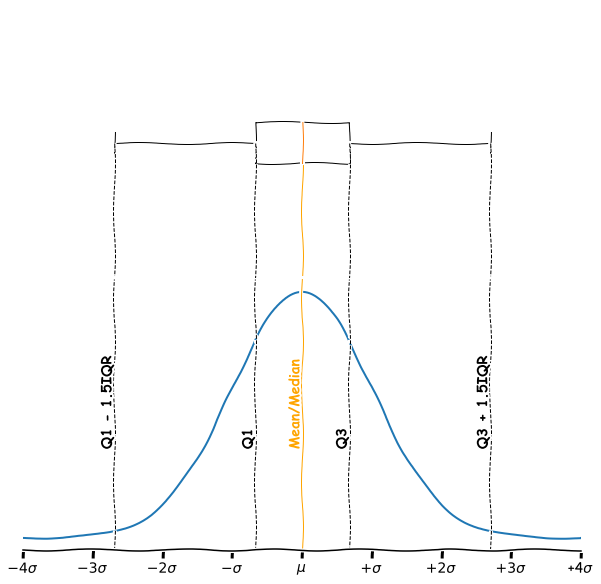

In [183]:
from scipy.stats import norm, halfnorm

xs = np.linspace(-20, 20, 1000)
density = norm.pdf(xs, loc=0, scale=5)
rvs = norm.rvs(loc=0, scale=5, size=1000000, random_state=5)

q1, q3 = np.quantile(rvs, [0.25, 0.75])
iqr = q3 - q1

plt.xkcd()
fig = plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=None, hspace=0.0)
ax1, ax2 = fig.subplots(2, 1)
ax1.boxplot(rvs, vert=False, sym='', notch=False)
ax1.set_xlim([-20, 20])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.plot(xs, density)
ax2.set_xlim([-20, 20])
ax2.set_yticks([])
ax2.set_xticks([-20, -15, -10, -5, 0, 5, 10, 15, 20])
ax2.set_xticklabels(['$-4\sigma$', r'$-3\sigma$', r'$-2\sigma$', r'$-\sigma$', r'$\mu$', r'$+\sigma$', r'$+2\sigma$', r'$+3\sigma$', r'+4$\sigma$']
)

ax2.axvline(0, color='orange', linewidth=1)
ax2.text(-1, 0.03, 'Mean/Median', rotation=90, color='orange', weight='bold')
ax1.axvline(0, color='orange', ymax=0.5, linewidth=1)

ax1.axvline(q3, linewidth=1, linestyle='--', ymax=0.5, color='black')
ax2.axvline(q3, linewidth=1, linestyle='--', color='black')
ax2.text(q3 - 1, 0.03, 'Q3', rotation=90, color='black', weight='bold')

ax1.axvline(q1, linewidth=1, linestyle='--', ymax=0.5, color='black')
ax2.axvline(q1, linewidth=1, linestyle='--', color='black')
ax2.text(q1 - 1, 0.03, 'Q1', rotation=90, color='black', weight='bold')

ax1.axvline(q1 - 1.5*iqr, linewidth=1, linestyle='--', ymax=0.5, color='black')
ax2.axvline(q1 - 1.5*iqr, linewidth=1, linestyle='--', color='black')
ax2.text(q1 - 1.5*iqr -1, 0.03, 'Q1 - 1.5IQR', rotation=90, color='black', weight='bold')

ax1.axvline(q3 + 1.5*iqr, linewidth=1, linestyle='--', ymax=0.5, color='black')
ax2.axvline(q3 + 1.5*iqr, linewidth=1, linestyle='--', color='black')
ax2.text(q3 + 1.5*iqr - 1, 0.03, 'Q3 + 1.5IQR', rotation=90, color='black', weight='bold')

In [38]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=500, max_samples=0.5)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

median_absolute_error(y_test, rf_pred)

TypeError: __init__() got an unexpected keyword argument 'max_samples'

In [60]:
from sklearn.model_selection import GridSearchCV

model_selector = GridSearchCV(
    DecisionTreeRegressor(random_state=42), 
    param_grid={
        'min_samples_leaf': np.arange(1, 21)
    },
    scoring='neg_median_absolute_error',
    cv=3
)

model_selector.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=42,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Fal

In [61]:
model_selector.best_params_

{'min_samples_leaf': 4}

In [62]:
model_selector.best_score_

-0.8397718210013293

In [63]:
best_tree = model_selector.best_estimator_

In [64]:
best_pred = best_tree.predict(X_test)

median_absolute_error(y_test, best_pred)

0.7416666666666671

In [65]:
best_tree.score(X_test, y_test)

0.8507434027835468

In [33]:
from sklearn import __version__
from sklearn.ensemble import RandomForestRegressor

__version__

'0.22'

In [43]:
rf = RandomForestRegressor(n_estimators=100, max_features=12)
rf.fit(X_train, y_train)

median_absolute_error(y_test, rf.predict(X_test))

ValueError: max_features must be in (0, n_features]

In [64]:
from sklearn.ensemble import RandomForestRegressor

np.random.seed(42)

forest_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('forest', RandomForestRegressor(n_estimators=100))
])

forest_selector = GridSearchCV(
    forest_pipeline,
    param_grid = {
        'forest__max_features': np.arange(5, 12)
    },
    scoring='neg_median_absolute_error',
    cv=3
)
    
forest_selector.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        SimpleImputer(add_indicator=False,
                                                      copy=True,
                                                      fill_value=None,
                                                      missing_values=nan,
                                                      strategy='mean',
                                                      verbose=0)),
                                       ('forest',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',


In [65]:
print(forest_selector.best_params_)
best_forest = forest_selector.best_estimator_

{'forest__max_features': 8}


In [67]:
best_forest_preds = best_forest.predict(X_test)
best_forest_medae = median_absolute_error(y_test, best_forest_preds)

print("[Random Forest] MedAE = {:.2f}".format(best_forest_medae))

[Random Forest] MedAE = 0.61


In [69]:
from utils import estimate_forest_variance

np.random.seed(42)

best_forest_variance = estimate_forest_variance(
    X_train, y_train, max_features=8
)

print("[Random Forest] Variance = {:.2f}".format(best_forest_variance))

[Random Forest] Variance = 1.52


In [48]:
rf_fixed = RandomForestRegressor(n_estimators=500)
rf_fixed.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
ys_preds = rf_fixed.predict(X_test)
median_absolute_error(y_test, ys_preds)

0.646240000000009

In [3]:
import numpy as np

np.random.seed(42)

n_samples = 10
weights = np.ones((n_samples,), dtype=np.float64)

sampled_indecies = np.random.randint(0, n_samples, n_samples)
print(sampled_indecies)
samples_counts = np.bincount(sampled_indecies, minlength=n_samples)
print(samples_counts)

weights *= samples_counts
print(weights)

[6 3 7 4 6 9 2 6 7 4]
[0 0 1 1 2 0 3 2 0 1]
[0. 0. 1. 1. 2. 0. 3. 2. 0. 1.]
